In [1]:
import sys
sys.path.append('../')
import torch
import dill
import os.path as op
import numpy as np
import hnn_core
from hnn_core import simulate_dipole, Network, read_params, JoblibBackend
import matplotlib as mpl
import matplotlib.pyplot as plt
import sbi.utils as utils
from sbi.inference.base import infer
import multiprocessing
import datetime
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from scipy import interpolate
import glob
import pandas as pd
import spike_train_functions
import hnn_simnets_functions
import numba
import sbi_functions
from sbi_functions import run_simulator
from joblib import Parallel, delayed
import umap
import umap.plot


/home/ntolley/anaconda3/lib/python3.7/site-packages/elephant/pandas_bridge.py:22: DeprecationWarning: pandas_bridge module will be removed in Elephant v0.8.x
  DeprecationWarning)
/home/ntolley/anaconda3/lib/python3.7/site-packages/holoviews/operation/datashader.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Callable


In [5]:
data_path = '/home/ntolley/Jones_Lab/sbi_hnn/data/beta/prerun_simulations/beta_event_t10000_01152021_161512/'

prior_dict_file = open(data_path + 'prior_dict_beta_event_t10000_01152021_161512.pkl', 'rb')
prior_dict = dill.load(prior_dict_file)
prior_dict_file.close()

prior_file = open(data_path + 'prior_beta_event_t10000_01152021_161512.pkl', 'rb')
prior = dill.load(prior_file)
prior_file.close()

# params_fname_file = open(data_path + 'params_fname_beta_event_t10000_01152021_161512.pkl', 'rb')
# params_fname = dill.load(params_fname_file)
# params_fname_file.close()
params_fname = '../../data/beta/params/beta_param.param'

dpl_files = sorted(glob.glob(data_path + 'data/*dpl_sim*'))
theta_files = sorted(glob.glob(data_path + 'data/*theta_sim*'))
spike_gids_files = sorted(glob.glob(data_path + 'data/spike_gids*'))
spike_times_files = sorted(glob.glob(data_path + 'data/spike_times*'))
spike_types_files = sorted(glob.glob(data_path + 'data/spike_types*'))

In [4]:
# file_idx = 0
# dpl = np.loadtxt(dpl_files[file_idx],delimiter=',')
# theta = np.loadtxt(theta_files[file_idx],delimiter=',')

dpl = np.vstack([np.loadtxt(dpl_files[file_idx],delimiter=',') for file_idx in range(len(dpl_files))])
theta = np.vstack([np.loadtxt(theta_files[file_idx],delimiter=',') for file_idx in range(len(theta_files))])

conv_dpl = np.loadtxt('../../data/beta/alpha_event_grant/rACC_flipCONV_r31_avg.csv', delimiter=',')
no_conv_dpl = np.loadtxt('../../data/beta/alpha_event_grant/rACC_flipNO_CONV_r31_avg.csv', delimiter=',')





ValueError: need at least one array to concatenate

In [3]:
inference = SNPE(prior=prior)
inference = inference.append_simulations(torch.as_tensor(theta).float(), torch.as_tensor(dpl).float())
density_estimator = inference.train()
posterior = inference.build_posterior(density_estimator)

NameError: name 'theta' is not defined

In [4]:
#___Save posterior___
save_file = open(data_path + 'posterior.pkl', 'wb')
dill.dump(posterior, save_file)
save_file.close()

#___Load posterior___
# posterior_file = open(data_path + 'posterior.pkl', 'rb')
# posterior = dill.load(posterior_file)
# posterior_file.close()

In [5]:
num_samples = 10
theta_samples_No = posterior.sample((num_samples,), x=ERPNo_dpl)
theta_samples_Yes = posterior.sample((num_samples,), x=ERPYes_dpl)

In [6]:
res_No = Parallel(n_jobs=8)(delayed(run_simulator)(theta_samples_No[sim_idx,:], params_fname, prior_dict, sim_idx) for sim_idx in range(num_samples))
res_Yes = Parallel(n_jobs=8)(delayed(run_simulator)(theta_samples_Yes[sim_idx,:], params_fname, prior_dict, sim_idx) for sim_idx in range(num_samples))


Text(0.5, 1.0, 'Inferred ERPs')

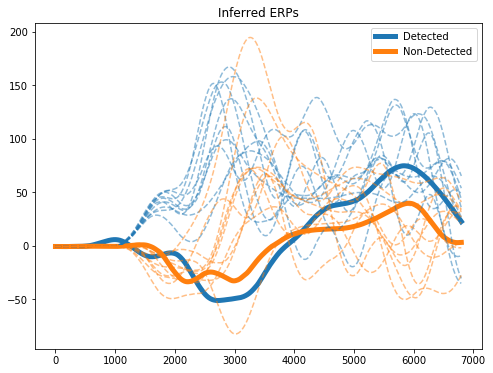

In [39]:
plt.figure(figsize=(8,6))
plt.plot(ERPYes_dpl, 'C0', LineWidth=5)
plt.plot(ERPNo_dpl, 'C1',LineWidth=5)
plt.legend(['Detected', 'Non-Detected'])
for sim_idx in range(len(res_Yes)):
    plt.plot(res_Yes[sim_idx][0], 'C0', LineStyle='--', alpha=0.5)
for sim_idx in range(len(res_No)):
    plt.plot(res_No[sim_idx][0], 'C1', LineStyle='--', alpha=0.5)

plt.title('Inferred ERPs')
